Dashboard building with temperature and abudannce of specific pollinators

import the necessary libraries

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Import Data

In [20]:
x = "pollinator_count_data-final.csv"
y = pd.read_csv("plant_on_campus_frequency.csv", sep = ',')

Clean up the imported data

In [128]:
#want to convert acronyms to full names 
#(hoverfly, honeybee, bumblebee, sweatbee, wasp, leafcutter, fly, beatle, butterfly)

def clean_data(df):

    #setting to print all the rows 
    pd.set_option('display.max_rows', None)

    #plants on campus data 
    df_frequency = pd.read_csv("plant_on_campus_frequency.csv",sep = ',')

    #convert european carder bee ( ECB), mason bee and carpenter bee to the leafcutter bee group (LF)
    df['pollinator'] = df['pollinator'].replace(['ECB','MB','CB'],'LB')
    #convert No information (NI) and unidentified bee (UB) to the Other pollinator group (OP)
    df['pollinator'] = df['pollinator'].replace(['NI','UB'],'OP')

    #replacing values within dataframe to favored/changed names exp. Bumble
    df['pollinator'] = df['pollinator'].replace(['BUT'],'Butterfly')
    df['pollinator'] = df['pollinator'].replace(['W'],'Wasp')
    df['pollinator'] = df['pollinator'].replace(['HF'],'Hover Fly')
    df['pollinator'] = df['pollinator'].replace(['BVO','BS','BMI','BME','BU','BI','BFL','BF','BB'],'Bumble')
    df['pollinator'] = df['pollinator'].replace(['SB'],'Sweat')
    df['pollinator'] = df['pollinator'].replace(['HB'],'Honey')
    df['pollinator'] = df['pollinator'].replace(['LB'],'Leaf Cutter')



    #using where statement to seperate OP to beetles and flies 

    # beetle 
    df['pollinator'] = np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'coleoptera'), 'Beetle', df['pollinator'])
    #print(df['pollinator'])

    # flies 
    df['pollinator'] =  np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'diptera'),'Fly',df['pollinator'] )
    #print(df[['pollinator','insect_order']])

    #droping all other pollinator from the data because not interested in other pollinators in data analysis
    df = df.drop(df[df['pollinator'] == 'OP'].index)
    #print(df[['pollinator','insect_order']])

    return df

In [22]:

#find the count of pollinator groups in the csv and return a percentage
pol_count = df.groupby(['pollinator'])['pollinator'].count()
print('The individual pollinator count: \n', pol_count)
print('The # of total pollinators: \n', len(df))
print('Percentage of pollinator distribution count: \n',(pol_count/len(df))*100)

The individual pollinator count: 
 pollinator
Beetle          14
Bumble         602
Butterfly       17
Fly             41
Honey          581
Hover Fly      304
Leaf Cutter     29
Sweat          267
Wasp            48
Name: pollinator, dtype: int64
The # of total pollinators: 
 1903
Percentage of pollinator distribution count: 
 pollinator
Beetle          0.735681
Bumble         31.634262
Butterfly       0.893326
Fly             2.154493
Honey          30.530741
Hover Fly      15.974777
Leaf Cutter     1.523910
Sweat          14.030478
Wasp            2.522333
Name: pollinator, dtype: float64


Adding in data regarding the date into seperate columns

In [129]:
def give_time(df):

    df['sample_date'] = pd.to_datetime(df['sample_date'])
    df['month'] = df['sample_date'].dt.month
    df['Week'] = df['sample_date'].dt.week -20
    df['day_of_year'] = df['sample_date'].dt.dayofweek

    #Get a column of the start of the week of all datetime objects
    df['datetime_monday_week'] = df['sample_date'].dt.to_period('W').dt.start_time
    return df
	


Define a function which would give the average temperature 

In [130]:
def line_temp_plot(data_set):
	
	#TEST to find missing temperatures in data 
	#Result : found missing time data for C0: E and C10: A --> both have no data for count in pollinator
	#must hardcode into data as no pollinator 
	count_test = data_set.groupby(['location_number','time_code'])['location_number'].count()
	count_test = count_test.reset_index(name='counts')
	#print(count_test)

	#results 
	# week = 20 , air_temp = 15, time_code = 'E', location_number = 'CO', counts = 0
	# week = 35 , air_temp = 23, time_code = 'A', location_number = 'C10', counts = 0
	#print(data_set.columns)
	num_plot_week = data_set.groupby(['Week','air_temp','time_code','location_number'])['air_temp'].count()
	num_plot_week = num_plot_week.reset_index(name = 'counts')
	pd.set_option('display.max_rows', None)
	
	num_plot_week.loc[len(num_plot_week)] = [20,15,'E','C0',0]
	num_plot_week.loc[len(num_plot_week)] = [35,23,'A','C10',0]
	#print('test_run','\n',num_plot_week)


	num_plot_week = num_plot_week.groupby(['Week'])['air_temp'].mean()
	num_plot_week = num_plot_week.reset_index(name = 'avg_air_temp')
	data_set = pd.merge(data_set, num_plot_week)
	
	#print(data_set)
	return data_set

In [131]:


def average_per_week(request):
	#observation data for pollinators
	data_set = pd.read_csv(x,sep = ',')
	data_set = clean_data(data_set)
	data_set = give_time(data_set)
	#Test Case :1
	# #print("Test Case : 
	#1", "\n",data_set['datetime_monday_week'])
	# 
	# #find the total number of pollinators according to location number and time code
	if(request == 'average'):
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
	else:
		#print(data_set['pollinator'].unique())
		data_set = data_set[(data_set['pollinator'] == request)]
		#print(data_set)
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
	
	#Test Case :2
	#print("Test Case : 2", "\n",data_set)

	#creating average temerapture for all plots 
	data_set = line_temp_plot(data_set)

	#getting the average pollinator mean 
	data_set['pol_mean'] = data_set.groupby(['datetime_monday_week'])['total_counts'].transform('mean')

	#finding the unique average air temperature by using .last()
	data_set = data_set.groupby(['datetime_monday_week','pol_mean'])['avg_air_temp'].last()
	data_set = data_set.reset_index(name = 'avg_temp')
	#print(data_set)

	#test if statistically significant with linear regression 
	#significant = scatter( data_set['avg_temp'], data_set['pol_mean'])

	#plotting the graph

	fig, ax1 = plt.subplots(figsize=(10, 8))

	ax1.plot(data_set['datetime_monday_week'], data_set['pol_mean'], color = 'red')
	ax2 = ax1.twinx()
	ax2.plot(data_set['datetime_monday_week'],data_set['avg_temp'], color = 'blue')

	#changing the scale of the x axis of the graph
	#ax1.set_yticks(np.linspace(5, 95, 10))
	#ax1.set_ylim(5,95)
	#ax2.set_yticks(np.linspace(12, 30, 10))
	
	#ax2.legend(loc=0)
	#plt.legend(bbox_to_anchor = (0.75, 1.15), ncol = 2)

	ax2.set_ylim(ax1.get_ylim())
	ax2.grid(True)

	ax1.set_xlabel('Week', fontsize = 17)
	
	ax1.set_ylabel('Pollinator Average Count', fontsize = 17)
	ax1.tick_params(axis = "y", labelcolor = 'red', labelsize = 15)
	ax1.tick_params(axis = 'x',labelsize = 15 )
	ax1.xaxis.grid()
	ax1.yaxis.grid()

	ax2.set_ylabel("Average Air Temp (C°)", fontsize = 17)
	ax2.tick_params(axis = 'y', labelcolor = 'blue',labelsize = 15)

	#ax1.legend(loc='best', fontsize = '80')

	fig.suptitle('Average Pollinator Count and Temperature Across 14 Weeks', fontsize = 20)
	fig.autofmt_xdate()

	
	plt.savefig('pollinator_avg_week.png',dpi = 500)

	plt.show()

C:\Users\lizzy\AppData\Local\Temp/ipykernel_4744/3405447219.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['sample_date'].dt.week -20


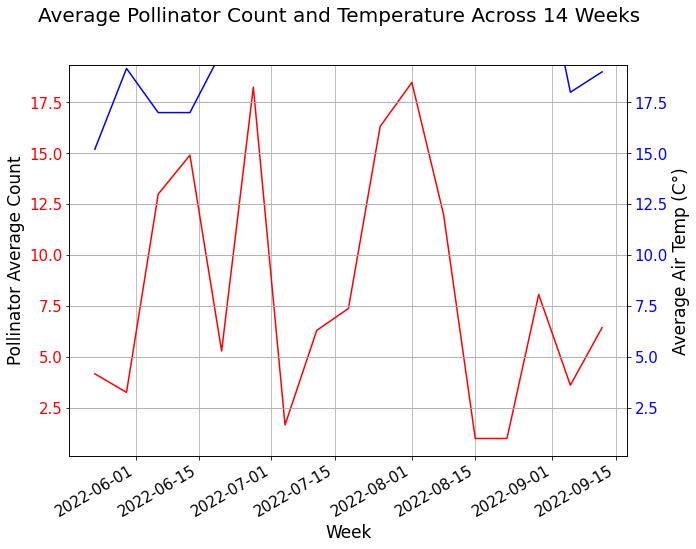

In [132]:
#print(df)
average_per_week('Bumble')

Starting the building of a dashboard
import the necessary libraries

In [133]:

import plotly.express as px

import ipywidgets as widgets

#from ipywidgets import interact
#%matplotlib widget
import seaborn as sb

Create the dashboard data filter parameters

In [134]:
#using ipywidgets
#data_set, request
widgets.interact(average_per_week,request = df['pollinator'].unique())

interactive(children=(Dropdown(description='request', options=('Bumble', 'Butterfly', 'Honey', 'Hover Fly', 'L…

<function __main__.average_per_week(request)>